# Code to Extract ESPN Game Win Probability

In [217]:
from lxml import html
from lxml.cssselect import CSSSelector
import requests

import pandas as pd

import json

css = CSSSelector

win_pct_marker = "espn.gamepackage.probability.data = "

def is_wins(x):
    return win_pct_marker in x

def extract_other_wins(doc):
    scripts = css("script")(doc)
    target_script = next(script for script in scripts if is_wins(script.text_content()))
    js = target_script.text_content()
    target_line = next(line for line in js.splitlines() if is_wins(line))
    start = target_line.find(win_pct_marker)
    data = target_line[start + len(win_pct_marker):-1]
    parsed = json.loads(data)
    return parsed

def extract_game_data(src):
    doc = html.fromstring(src)
    primary_win_pct = css(".header-win-percentage")(doc)[0].text_content()
    other_win_pcts = extract_other_wins(doc)
    return (primary_win_pct, other_win_pcts)

def convert_gamedata_to_df(score):
    df = pd.DataFrame(score[1])
    df['awayScore'], df['clockdisplayValue'], df['homeScore'], \
    df['periodnumber'], df['startdistance'], df['startdown'], df['startteamid'], \
    df['startyardLine'], df['startyardsToEndzone'], df['playtext'], \
    df['playtypeabbreviation'], df['playtypeid'], df['playtypetext'] = zip(*df['play'].map(explode_play_col))
    
    df = df.drop('play', axis=1)
    return df

def explode_play_col(col):
    awayScore = col['awayScore']
    clockdisplayValue = col['clock']['displayValue']
    homeScore = col['homeScore']
    periodnumber = col['period']['number']
    startdistance = col['start']['distance']
    startdown = col['start']['down']
    try:
        startteamid = col['start']['team']['id']
    except:
        startteamid = None
    startyardLine = col['start']['yardLine']
    startyardsToEndzone = col['start']['yardsToEndzone']
    
    try:
        playtext = col['text']
    except:
        playtext = None
    
    try:
        playtypeabbreviation = col['type']['abbreviation']
    except:
        playtypeabbreviation = None
        
    try:
        playtypeid = col['type']['id']
    except:
        playtypeid = None
    
    try:
        playtypetext = col['type']['text']
    except:
        playtypetext = None
    return awayScore, clockdisplayValue, homeScore, periodnumber, startdistance, startdown, \
            startteamid, startyardLine, startyardsToEndzone, playtext, playtypeabbreviation, \
            playtypeid, playtypetext

In [220]:
# Run the code

url = 'http://www.espn.com/nfl/game?gameId=400927752'
src = requests.get(url)
score = extract_game_data(src.text)

df = convert_gamedata_to_df(score)

In [132]:
df.to_csv('superbowl_playbyPlay.csv')

## Plot Resulting Data

In [222]:
df.dtypes

homeWinPercentage       float64
playId                   object
secondsLeft               int64
tiePercentage             int64
awayScore                 int64
clockdisplayValue        object
homeScore                 int64
periodnumber              int64
startdistance             int64
startdown                 int64
startteamid              object
startyardLine             int64
startyardsToEndzone       int64
playtext                 object
playtypeabbreviation     object
playtypeid               object
playtypetext             object
dtype: object

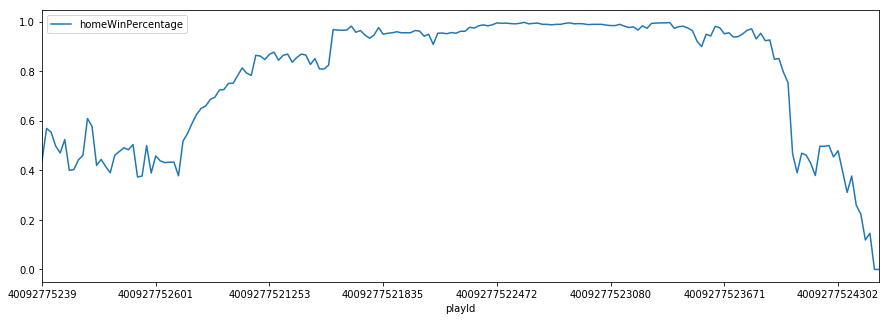

In [225]:
df.plot(x='playId', y='homeWinPercentage', figsize=(15,5))

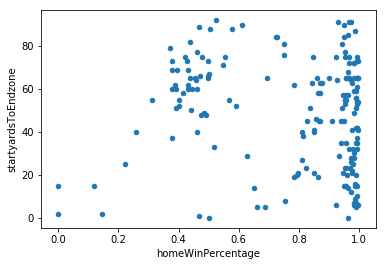

In [227]:
df.plot(x='homeWinPercentage', y='startyardsToEndzone', kind='scatter')

## Try a different game to see if code works

In [234]:
# AFC Championship Game
url = 'http://www.espn.com/nfl/game?gameId=400999172'
src = requests.get(url)
score = extract_game_data(src.text)

df_afc_champ2018 = convert_gamedata_to_df(score)

In [245]:
df_afc_champ2018['playId']

0        40099917236
1        40099917251
2        40099917279
3       400999172103
4       400999172124
5       400999172149
6       400999172173
7       400999172190
8       400999172231
9       400999172255
10      400999172279
11      400999172298
12      400999172317
13      400999172355
14      400999172376
15      400999172400
16      400999172427
17      400999172451
18      400999172475
19      400999172496
20      400999172518
21      400999172540
22      400999172559
23      400999172583
24      400999172604
25      400999172625
26      400999172646
27      400999172664
28      400999172688
29      400999172712
           ...      
145    4009991723415
146    4009991723437
147    4009991723459
148    4009991723478
149    4009991723499
150    4009991723521
151    4009991723543
152    4009991723568
153    4009991723592
154    4009991723619
155    4009991723643
156    4009991723664
157    4009991723704
158    4009991723719
159    4009991723743
160    4009991723772
161    400999

In [250]:
df_afc_champ2018['playnumber'] = df_afc_champ2018['playId'].apply(lambda x: int(str(x).replace('400999172', ' ')))

In [253]:
df_afc_champ2018['awayWinPercentage'] = df_afc_champ2018['homeWinPercentage'].apply(lambda x: 1-x)

In [257]:
df_afc_champ2018 = df_afc_champ2018.sort_values('playnumber')

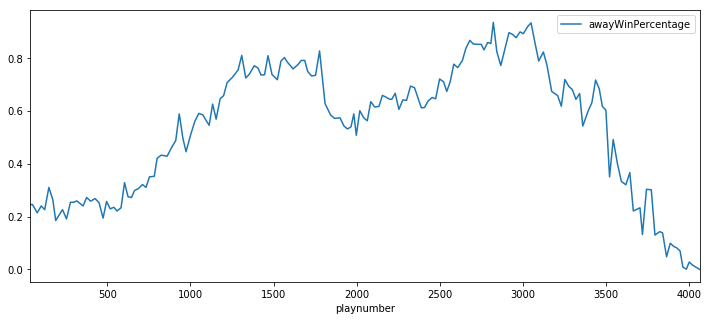

In [258]:
df_afc_champ2018.plot(x='playnumber', y='awayWinPercentage', figsize=(12,5))

# Configure Tweets

In [207]:
import tweepy
import datetime as dt
from configparser import ConfigParser

config = ConfigParser()
config.read('twitter.conf')

auth = tweepy.OAuthHandler(consumer_key=config['TWITTER']['CONSUMER_KEY'],
                           consumer_secret=config['TWITTER']['CONSUMER_SECRET'])
auth.set_access_token(key=config['TWITTER']['ACCESS_TOKEN'],
                      secret=config['TWITTER']['ACCESS_SECRET'])

api = tweepy.API(auth)


username = 'nfl_scores_pbp'
startDate = dt.datetime(2017, 2, 1, 0, 0, 0)
endDate =   dt.datetime(2017, 2, 10, 0, 0, 0)

tweets = []
tmpTweets = api.user_timeline(username)
for tweet in tmpTweets:
    if tweet.created_at < endDate and tweet.created_at > startDate:
        tweets.append(tweet)

while (tmpTweets[-1].created_at > startDate):
    print("Last Tweet @", tmpTweets[-1].created_at, " - fetching some more")
    tmpTweets = api.user_timeline(username, max_id = tmpTweets[-1].id)
    for tweet in tmpTweets:
        if tweet.created_at < endDate and tweet.created_at > startDate:
            tweets.append(tweet)
            



Last Tweet @ 2018-01-01 00:39:16  - fetching some more
Last Tweet @ 2017-12-31 23:41:13  - fetching some more
Last Tweet @ 2017-12-31 22:10:30  - fetching some more
Last Tweet @ 2017-12-31 20:16:14  - fetching some more
Last Tweet @ 2017-12-31 18:45:17  - fetching some more
Last Tweet @ 2017-12-26 00:04:05  - fetching some more
Last Tweet @ 2017-12-25 00:04:36  - fetching some more
Last Tweet @ 2017-12-24 20:20:11  - fetching some more
Last Tweet @ 2017-12-24 19:18:11  - fetching some more
Last Tweet @ 2017-12-24 18:16:08  - fetching some more
Last Tweet @ 2017-12-19 04:19:06  - fetching some more
Last Tweet @ 2017-12-18 00:24:15  - fetching some more
Last Tweet @ 2017-12-17 21:28:15  - fetching some more
Last Tweet @ 2017-12-17 20:19:12  - fetching some more
Last Tweet @ 2017-12-17 19:43:09  - fetching some more
Last Tweet @ 2017-12-17 18:13:53  - fetching some more
Last Tweet @ 2017-12-12 03:53:04  - fetching some more
Last Tweet @ 2017-12-10 21:14:17  - fetching some more
Last Tweet

In [262]:
df = pd.DataFrame()

for tweet in tweets:
    df['text'] = tweet.text
    df['created_at'] = tweet.created_at
    df['author'] = tweet.author

In [264]:
for tweet in tweets:
    print(tweet.text)

(11:08) J.White right end for 2 yards, TOUCHDOWN. #NEvsATL
(1:00) J.White right guard for 1 yard, TOUCHDOWN. #NEvsATL
(6:00) (Shotgun) T.Brady pass short left to D.Amendola for 6 yards, TOUCHDOWN. #NEvsATL
(9:48) S.Gostkowski 33 yard field goal is GOOD, Center-J.Cardona, Holder-R.Allen. #NEvsATL
(2:12) (Shotgun) T.Brady pass short left to J.White for 5 yards, TOUCHDOWN. #NEvsATL
(8:36) (Shotgun) M.Ryan pass short right to T.Coleman for 6 yards, TOUCHDOWN. #NEvsATL
(:05) S.Gostkowski 41 yard field goal is GOOD, Center-J.Cardona, Holder-R.Allen. #NEvsATL
2/2 TOUCHDOWN. #NEvsATL
1/2 (2:36) (Shotgun) T.Brady pass short left intended for D.Amendola INTERCEPTED by R.Alford at ATL 18. R.Alford for 82 yards, #NEvsATL
2/2 Interference, declined. #NEvsATL
1/2 (8:55) (Shotgun) M.Ryan pass deep left to A.Hooper for 19 yards, TOUCHDOWN. Penalty on NE-P.Chung, Defensive Pass #NEvsATL
(12:20) (Shotgun) D.Freeman up the middle for 5 yards, TOUCHDOWN. #NEvsATL
(12:20) (Shotgun) D.Freeman up the middle 

In [273]:
for tweet in tweets:
    print(tweet.author.name)
    print(tweet.text)

NFL Play By Play
(11:08) J.White right end for 2 yards, TOUCHDOWN. #NEvsATL
NFL Play By Play
(1:00) J.White right guard for 1 yard, TOUCHDOWN. #NEvsATL
NFL Play By Play
(6:00) (Shotgun) T.Brady pass short left to D.Amendola for 6 yards, TOUCHDOWN. #NEvsATL
NFL Play By Play
(9:48) S.Gostkowski 33 yard field goal is GOOD, Center-J.Cardona, Holder-R.Allen. #NEvsATL
NFL Play By Play
(2:12) (Shotgun) T.Brady pass short left to J.White for 5 yards, TOUCHDOWN. #NEvsATL
NFL Play By Play
(8:36) (Shotgun) M.Ryan pass short right to T.Coleman for 6 yards, TOUCHDOWN. #NEvsATL
NFL Play By Play
(:05) S.Gostkowski 41 yard field goal is GOOD, Center-J.Cardona, Holder-R.Allen. #NEvsATL
NFL Play By Play
2/2 TOUCHDOWN. #NEvsATL
NFL Play By Play
1/2 (2:36) (Shotgun) T.Brady pass short left intended for D.Amendola INTERCEPTED by R.Alford at ATL 18. R.Alford for 82 yards, #NEvsATL
NFL Play By Play
2/2 Interference, declined. #NEvsATL
NFL Play By Play
1/2 (8:55) (Shotgun) M.Ryan pass deep left to A.Hooper fo

In [301]:
# variables = arr[0].keys()
df = pd.DataFrame()
variables = ['text','created_at','source','user']
df = pd.DataFrame([[getattr(i,j) for j in variables] for i in tweets], columns = variables)

In [302]:
df.to_csv('')